In [87]:
import pandas as pd
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

El objetivo es determinar la orientación el 'optic disc' (OD) utilizando el tensor de datos que representa la imagen.
Esto permitirá reconocer la orientación de las imágenes del dataset de estudio y poder colocar todas con la misma orientación del OD.
Tener todas las imágenes con la misma orientación del OD podría mejorar el rendimiento del modelo.

In [15]:
image_dir = "../ODIR-5K/ODIR-5K/Training Images"
image_path = os.path.join(image_dir, '17_left.jpg')
img = cv2.imread(image_path)

Se va a utilizar la región central de la imagen. Si se divide verticalmente la imagen en tres partes, se escogerá la parte central.
Esta región se dividirá por su parte central en dos partes iguales ('left', 'right'). La comparación de estas dos zonas servirá para predecir la posición del OD.

In [ ]:
# Region
row_min = img.shape[0]//3
row_max = row_min*2

img_center_row = img[row_min:row_max,:,:]
img_center_row.shape

col_center = img.shape[1]//2
img_left = img_center_row[:,:col_center,:]
img_right = img_center_row[:,col_center:,:]

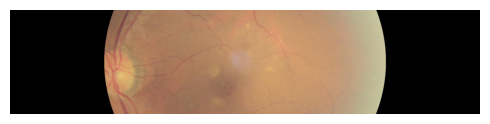

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(img_center_row[:,:,::-1])
plt.axis('off')
plt.tight_layout()
plt.show()

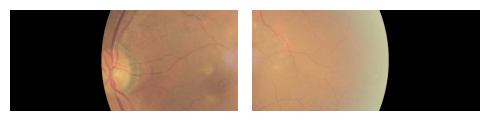

In [18]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(img_left[:,:,::-1])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_right[:,:,::-1])
plt.axis('off')
plt.tight_layout()
plt.show()

El parámetro utilizado para comparar las dos regiones y predecir la orientación será la media de los valores. Esta media se calculará para cada una de las capas RGB y para el conjunto completo de las tres capas.

In [94]:
# Param
# mean
print(img.mean())
print(img[:,:,0].mean())
print(img[:,:,1].mean())
print(img[:,:,2].mean())

51.6606381087541
14.641705524266992
48.253697033398666
91.14859758550122


Para probar este algoritmo de clasificación se utilizará el subconjunto 'Localization' del dataset 'IDRiD'. Este dataset cuenta con 413 imágenes para las que se conoce las coordenadas del OD.

In [56]:
# Read OD coodinates IDRiD
groundtruths_dir = "/home/mapardo/KeepCoding/finalProject/RD/IDRiD/C. Localization/2. Groundtruths/1. Optic Disc Center Location"
groundtruths_file = "a. IDRiD_OD_Center_Training Set_Markups.csv"
df_gt = pd.read_csv(os.path.join(groundtruths_dir,groundtruths_file))
df_gt = df_gt[['Image No', 'X- Coordinate', 'Y - Coordinate']]
df_gt.columns = ['fundus', 'x', 'y']
df_gt.head()

,fundus,x,y
0,IDRiD_001,2858.0,1805.0
1,IDRiD_002,943.0,1119.0
2,IDRiD_003,779.0,1269.0
3,IDRiD_004,1292.0,1284.0
4,IDRiD_005,1037.0,1198.0


Se extraen los valores medios para las dos regiones en el conjunto total de capas y para las tres capas de forma individual

In [55]:
# Calculate mean values for regions 'right' and 'left'. For each layer and total set of layers.
image_dir = "/home/mapardo/KeepCoding/finalProject/RD/IDRiD/C. Localization/1. Original Images/a. Training Set"
lst_images = os.listdir(image_dir)

left_mean = []
left_mean_0 = []
left_mean_1 = []
left_mean_2 = []
right_mean = []
right_mean_0 = []
right_mean_1 = []
right_mean_2 = []
width = []
for image in lst_images:
    image_path = os.path.join(image_dir, image)
    img = cv2.imread(image_path)
    
    # Region
    row_min = img.shape[0]//3
    row_max = row_min*2

    img_center_row = img[row_min:row_max,:,:]
    img_center_row.shape

    col_center = img.shape[1]//2
    img_left = img_center_row[:,:col_center,:]
    img_right = img_center_row[:,col_center:,:]
    
    # Parameters    
    width.append(img.shape[1])
    left_mean.append(img_left.mean())
    left_mean_0.append(img_left[:,:,0].mean())
    left_mean_1.append(img_left[:,:,1].mean())
    left_mean_2.append(img_left[:,:,2].mean())
    right_mean.append(img_right.mean())
    right_mean_0.append(img_right[:,:,0].mean())
    right_mean_1.append(img_right[:,:,1].mean())
    right_mean_2.append(img_right[:,:,2].mean())

lst_fundus = map(lambda x: x.replace('.jpg',''), lst_images)
df_params = pd.DataFrame({'fundus': lst_fundus, 'width': width, 'left_mean': left_mean, 'left_mean_0': left_mean_0, 
             'left_mean_1': left_mean_1, 'left_mean_2': left_mean_2,
             'right_mean': right_mean, 'right_mean_0': right_mean_0, 
             'right_mean_1': right_mean_1, 'right_mean_2': right_mean_2})

df_params.head()

,fundus,width,left_mean,left_mean_0,left_mean_1,left_mean_2,right_mean,right_mean_0,right_mean_1,right_mean_2
0,IDRiD_343,4288,71.344258,13.529273,59.787571,140.715929,48.635731,8.739387,40.699928,96.467880
1,IDRiD_108,4288,90.985743,22.045467,84.315690,166.596073,62.626837,11.225743,55.209385,121.445382
2,IDRiD_048,4288,82.483273,39.635498,75.006156,132.808166,57.696323,27.008840,51.409329,94.670800
3,IDRiD_154,4288,57.341738,1.105454,42.865763,128.053996,38.818495,0.959971,28.444766,87.050749
4,IDRiD_011,4288,77.355466,4.111626,70.574743,157.380028,48.298683,2.078042,40.281420,102.536588
...,...,...,...,...,...,...,...,...,...,...
408,IDRiD_207,4288,83.022871,14.203388,77.147564,157.717660,91.077522,23.342221,91.039762,158.850585
409,IDRiD_370,4288,70.370147,13.942697,60.797624,136.370121,70.920235,16.688038,64.113249,131.959417
410,IDRiD_344,4288,77.617760,14.013013,73.534709,145.305560,84.881807,21.219000,83.252375,150.174045
411,IDRiD_366,4288,55.657443,1.067904,42.216549,123.687877,40.284545,0.895649,28.120124,91.837863


In [57]:
df = pd.merge(df_params, df_gt, on='fundus')
df.head()

,fundus,width,left_mean,left_mean_0,left_mean_1,left_mean_2,right_mean,right_mean_0,right_mean_1,right_mean_2,x,y
0,IDRiD_343,4288,71.344258,13.529273,59.787571,140.715929,48.635731,8.739387,40.699928,96.467880,606.0,1145.0
1,IDRiD_108,4288,90.985743,22.045467,84.315690,166.596073,62.626837,11.225743,55.209385,121.445382,1003.0,1430.0
2,IDRiD_048,4288,82.483273,39.635498,75.006156,132.808166,57.696323,27.008840,51.409329,94.670800,884.0,1205.0
3,IDRiD_154,4288,57.341738,1.105454,42.865763,128.053996,38.818495,0.959971,28.444766,87.050749,745.0,1490.0
4,IDRiD_011,4288,77.355466,4.111626,70.574743,157.380028,48.298683,2.078042,40.281420,102.536588,1063.0,1329.0


A partir de la coordenada en x y la anchura de la imagen se clasifican las imágenes según la orientación del OD.

In [65]:
# classify fundus using width and x
df['position'] = 0
df.loc[df['x'] > df['width']//2, 'position'] = 1
df.head()


,fundus,width,left_mean,left_mean_0,left_mean_1,left_mean_2,right_mean,right_mean_0,right_mean_1,right_mean_2,x,y,position
0,IDRiD_343,4288,71.344258,13.529273,59.787571,140.715929,48.635731,8.739387,40.699928,96.467880,606.0,1145.0,0
1,IDRiD_108,4288,90.985743,22.045467,84.315690,166.596073,62.626837,11.225743,55.209385,121.445382,1003.0,1430.0,0
2,IDRiD_048,4288,82.483273,39.635498,75.006156,132.808166,57.696323,27.008840,51.409329,94.670800,884.0,1205.0,0
3,IDRiD_154,4288,57.341738,1.105454,42.865763,128.053996,38.818495,0.959971,28.444766,87.050749,745.0,1490.0,0
4,IDRiD_011,4288,77.355466,4.111626,70.574743,157.380028,48.298683,2.078042,40.281420,102.536588,1063.0,1329.0,0


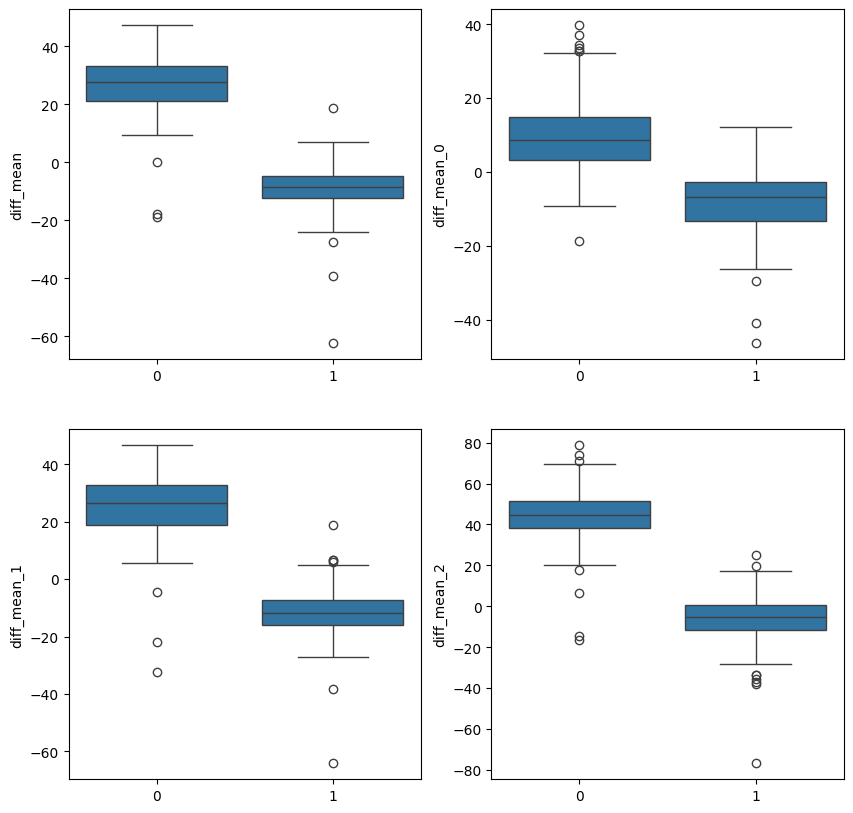

In [80]:
# boxplot for each parameters 0 vs 1 (diff_mean, diff_mean_0, diff_mean_1, diff_mean_2)
df['diff_mean'] = df['left_mean']- df['right_mean']
df['diff_mean_0'] = df['left_mean_0']- df['right_mean_0']
df['diff_mean_1'] = df['left_mean_1']- df['right_mean_1']
df['diff_mean_2'] = df['left_mean_2']- df['right_mean_2']
plt.figure(figsize=(10,10))
for i, param in enumerate(['diff_mean','diff_mean_0','diff_mean_1','diff_mean_2']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='position', y=param, data=df)
    plt.ylabel(param)
    plt.xlabel("")
plt.show()

In [91]:
# Classify using diff_mean, diff_mean_0, diff_mean_1, diff_mean_2
df = df[['fundus','diff_mean','diff_mean_0', 'diff_mean_1', 'diff_mean_2', 'position']]
df.head()
df['position_mean'] = df['diff_mean'].apply(lambda x: 0 if x > 0 else 1)
df['position_mean_0'] = df['diff_mean_0'].apply(lambda x: 0 if x > 0 else 1)
df['position_mean_1'] = df['diff_mean_1'].apply(lambda x: 0 if x > 0 else 1)
df['position_mean_2'] = df['diff_mean_2'].apply(lambda x: 0 if x > 0 else 1)

print('Mean difference')
print(pd.crosstab(df['position'], df['position_mean']))
print(classification_report(df['position'], df['position_mean']))
print('Mean_0 difference')
print(pd.crosstab(df['position'], df['position_mean_0']))
print(classification_report(df['position'], df['position_mean_0']))
print('Mean_1 difference')
print(pd.crosstab(df['position'], df['position_mean_1']))
print(classification_report(df['position'], df['position_mean_1']))
print('Mean_2 difference')
print(pd.crosstab(df['position'], df['position_mean_2']))
print(classification_report(df['position'], df['position_mean_2']))

Mean difference
position_mean    0    1
position               
0              207    2
1               18  186
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       209
           1       0.99      0.91      0.95       204

    accuracy                           0.95       413
   macro avg       0.95      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413

Mean_0 difference
position_mean_0    0    1
position                 
0                200    9
1                 15  189
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       209
           1       0.95      0.93      0.94       204

    accuracy                           0.94       413
   macro avg       0.94      0.94      0.94       413
weighted avg       0.94      0.94      0.94       413

Mean_1 difference
position_mean_1    0    1
position                 
0                206    3
1               

In [ ]:
# Failed images. Why?